## Monte Carlo Evaluation
One advantage of Monte Carlo methods are that they don't require a model of the enviroment (e.g. the $p(s' | s, a)$ and $r(s,a,s')$ in Bellman equation).

In a nutshell, Monte Carlo methods collect statistics about $v(s)$ and $q(s, a)$. 

Take $v(s)$ as an example. This is defined as $\mathbb{E}(G_t | S_t = s)$ for any $t$. In the first-visit MC methods, we are only interested in the expected return from state $s$ after the very first visit, so we don't worry about the time index $t$. There are also every-visit MC methods. In Sutton's book, first-visit MC is the focus. 

Given state $s$, we think the return $G$ from any epsidoe is sampled from some distribution $p_s(G)$. We are not interested in the exact form of $p_s(G)$; in fact, that would require modeling of the enviroment. All we do is following the policy a number of times, and at the end of each episode, we have a sample $G$ from $p_s(G)$. Then $$v(s) = \mathbb{E}(G | s) \approx \frac{1}{N} \sum_i G_i$$

For example, suppose we have state sequence $S_0 S_1 S_2 S_1 S_3$ in one episode. $S_3$ is the terminating state and we get reward $x$ during the transition $S_1 \rightarrow S_3$, and zero reward in all other transitions. Suppose the discount facotr is $\gamma$. With this setup, $S_2$ gets a sample return $\gamma x$ and $S_1$ gets a sample return $\gamma^2 x$. Note only the first appearence of $S_1$ cares about the sample return. 

$q(s,a)$ is computed in the similar fashion.

## Monte Carlo Control
After each episode, update $q(s, a)$. For every state $s$ in episode, set $\pi(s) = \text{argmax}_a q(s,a)$.
A variant is the $\epsilon$-soft on-policy.


## Blackjack
Single deck blackjack. Dealer's strategy: sticks on any sum of 17 or greater. What strategy should the player have?

Player's state can be described by two variables: 1) The current sum (in the maximum sense); 2) Whether he has an ACE that can be used as 1 instead of 11. (There are alternatives to define the state.)

For example, suppose the player has {4, 5, 1} at hand, then the state is <20, TRUE>, where 20 is the sum of 4, 5, 11 and TRUE indicates he has an ACE usable as 1. If player hits and get another card 3, then the state becomes <13, FALSE>.

The overall state can be described by the above two factors, plus dealer's one visible card: one of {ACE, 2, ... 10}. For player's state, we are only intereted in the case where the current sum is greater than or equals to 12; otherwise, we can always hit can get a better chance of winning.



## Implementation
The code is organized as follows:
1. Define some constants and util functions.
    * The state is modeled as a tuple: (player's maximum possible sum, whether or not player has a usable ace, dealer's first card)
    * A helper function to convert cards (all player's cards and dealer's first card) to the state tuple.
2. Define a base class `BasePlayer`, inherited by `Dealer` and `PolicyPlayer`.
3. Define `Policy` and `PolicyPlayer`.
    * A policy updates the state-action value functions via `update_q()`
    * A policy updates the policy function via `update_pi()`
    * A policy has an `action()` method that maps state tuple to one of {stick, hit}.
4. Define a `Game` class, that can starts a game for the dealer and the player.
5. A `Learner` class that can play game for many times and keep updating the policy.

In [4]:
# Define some constants and utils.

import random
import numpy as np
from scipy.stats import beta

DECK_OF_CARDS = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4 #J, Q, K count as 10.
SMALLEST_INTERESTING_SUM = 12 # We should always hit if sum is less than 12.
DEALDER_STICK_THRESHOLD = 17
DEBUG_ON = False

def gen_states():
    s = []
    for i in range(SMALLEST_INTERESTING_SUM, 21, 1):
        for j in range(2):
            for k in range(1, 11, 1):
                s.append((i,j,k))
    return s

INTERESTING_STATES = gen_states()

def sum_hand(hand):
    min_s = sum(hand)
    max_s = sum(hand)
    if 1 in hand:
        max_s = min_s  + 10
    if max_s <= 21 and max_s > min_s:
        ## Has a usable ACE.
        return (max_s, True)
    else:
        return (min_s, False)
    
def busted(hand):
    (s, _) = sum_hand(hand)
    return s > 21    
    
def convert_cards_to_state(my_cards, dealer_card):
    (s, usable_ace) = sum_hand(my_cards)
    return (s, usable_ace, dealer_card)

def beta_policy(a1, b1, a2, b2, sample_size = 100):
    s1 = beta.rvs(a1, b1, size=sample_size)
    s2 = beta.rvs(a2, b2, size=sample_size)
    return np.sum(s1 >= s2) * 1.0 / sample_size

# a1,b1 = win and loss for stick
def beta_policy_action(a1, b1, a2, b2):
    s1 = beta.rvs(a1, b1, size=1)
    s2 = beta.rvs(a2, b2, size=1)
    if s1[0] > s2[0]:
        return 0
    else:
        return 1

In [5]:
class BasePlayer:
    def action(self, cards, rival_card):
        raise NotImplementedError("action() is not implemented. Return 1 if hit, 0 if stick.")

class Dealer(BasePlayer):
    def __init__(self):
        self.stick_threshold = DEALDER_STICK_THRESHOLD
    def action(self, cards, rival_card):
        (s, _) = sum_hand(cards)
        if s < self.stick_threshold:
            return 1
        else:
            return 0

In [21]:
EPSILON = 0.0  # epsilon-greedy
class Policy:
    def __init__(self):
        # key: state; value: array of 2, indicating value of stick or hit.
        self.q = {}
        # key: state; value = array of 2, indicating p(stick|s) and p(hit|s)
        self.pi = {}
        # An aribitrary initialization.
        for x in INTERESTING_STATES:
            self.q[x] = [0.5, 0.5]
        for x in INTERESTING_STATES:
            self.pi[x] = [0.5, 0.5]
        # This is a map, recording the number of times we have experienced state-action pair.    
        self.num_occurences = {}
        self.loss_win = {}
        ## Init win_loss counts
        for s in INTERESTING_STATES:
            for action in range(2):
                self.loss_win[(s, action)] = [1, 1]
        self.episodes = 0;
        
    def action(self, state):
        if state in INTERESTING_STATES:
            (b1, a1) = self.loss_win[(state, 0)]
            (b2, a2) = self.loss_win[(state, 1)]            
            return beta_policy_action(a1, b1, a2, b2)
            #prob = self.pi[state]
            #assert abs(sum(prob) - 1) < 1e-6 and len(prob) == 2
            #r = random.random()
            #if r <= prob[0]:
            #    return 0
            #else:
            #    return 1
        else:
            (i, j, k) = state
            assert i < SMALLEST_INTERESTING_SUM or i == 21
            if i < SMALLEST_INTERESTING_SUM:
                return 1
            else:
                return 0
    def update_q(self, state_action_pairs, reward):
        if DEBUG_ON:
            print 'updating action values with state-action pairs:', state_action_pairs
            print 'reward was ', reward
        # First occurance Monte Carlo. We only care unique terms.
        unique_pairs = list(set(state_action_pairs))
        for kv in unique_pairs:
            (state, action) = kv
            if state in INTERESTING_STATES:
                n = self.num_occurences.get((state, action), 0)
                n += 1
                self.num_occurences[(state, action)] = n
                if reward == -1:
                    self.loss_win[(state, action)][0] += 1
                elif reward == 1:
                    self.loss_win[(state, action)][1] += 1
                else:
                    self.loss_win[(state, action)][0] += 1
                    self.loss_win[(state, action)][1] += 1
                # Online update of q(s, a). q(s, a) records the likelihood of winning
                # if we take action `a` on state `s`. q(s, a) gives raw statistics, and
                # is not greedy.
                if DEBUG_ON:
                    print 'updating an interesting state-action pair: {}, {}'.format(state, action)
                if n == 1:
                    if DEBUG_ON:
                        print 'first time experience, updating to {}'.format(reward)
                    (self.q[state])[action] = reward
                else:
                    old = (self.q[state])[action]
                    new = old + (1.0 / n) * (reward - old)
                    (self.q[state])[action] = new
                    if DEBUG_ON:
                        print '{}-th time; updating state-action value from {} to {}'.format(n, old, new)
                
    def update_pi(self, state_action_pairs):
        unique_pairs = list(set(state_action_pairs))
        for kv in unique_pairs:
            (state, action) = kv
            if state in INTERESTING_STATES:
                # beta strategy
                #(b1, a1) = self.loss_win[(state, 0)]
                #(b2, a2) = self.loss_win[(state, 1)]
                #r = beta_policy(a1, b1, a2, b2)
                #self.pi[state] = [r, 1 - r]
                
                # q(s, a) where a = 0 or 1
                qs = self.q[state]
                #v = [qs[0] + EPSILON, qs[1] + EPSILON]
                #self.pi[state] = list(np.divide(v, 1.0 * sum(v)))
                # Set epsilon-greedy policy.
                if qs[0] >= qs[1]:
                    self.pi[state] = [1.0 - EPSILON, EPSILON]
                else:
                    self.pi[state] = [EPSILON, 1.0 - EPSILON]
                if DEBUG_ON:
                    print 'set epsilon-greedy policy for state {} to {}'.format(state, self.pi[state])
    def finalize_policy(self):
        for state in self.q:
            qs = self.q[state]
            # Set epsilon-greedy policy.
            if qs[0] >= qs[1]:
                self.pi[state] = [1.0 , 0.0]
            else:
                self.pi[state] = [0.0, 1.0]
    def compute_summary(self):
        self.summary = {}
        for state in self.pi:
            qs = self.q[state]
            loss_and_win_stick = self.loss_win[(state, 0)]
            loss_and_win_hit = self.loss_win[(state, 1)]
            final_policy = self.pi[state]
            decision = 'stick' if final_policy[0] > final_policy[1] else 'hit'
            self.summary[state] = (qs, [loss_and_win_stick, loss_and_win_hit], decision)
    def strategy_matrix(self, usable_ace = False):
        ret = [['' for i in range(10)] for j in range(21 - SMALLEST_INTERESTING_SUM)]
        for i in range(SMALLEST_INTERESTING_SUM, 21, 1):
            for j in range(1, 11, 1):
                action = summary[(i, False, j)][-1]
                binary = 1 if action == 'hit' else 0
                ret[i - SMALLEST_INTERESTING_SUM][j - 1] = binary
        return ret
        
class PolicyPlayer(BasePlayer):
    def __init__(self, policy):
        self.policy = policy
        self.state_action_pairs = []
    def action(self, cards, rival_card):
        s = convert_cards_to_state(cards, rival_card)
        a = self.policy.action(s)
        self.state_action_pairs.append((s, a))
        return a
    def update_policy(self, reward):
        self.policy.update_q(self.state_action_pairs, reward)
        self.policy.update_pi(self.state_action_pairs)
        self.state_action_pairs = []
    def finalize_policy(self):
        self.policy.finalize_policy()

In [7]:
class Game:
    def __init__(self, dealer, player):
        self.dealer = dealer
        self.player = player
        self.dealer_cards = []
        self.player_cards = []
        self.cards = DECK_OF_CARDS[:]
        random.shuffle(self.cards)
        self.card_index = 0

    def player_hit(self):
        self.player_cards.append(self.cards[self.card_index])
        self.card_index +=1
        if DEBUG_ON:
            print 'player hits, current cards = ', self.player_cards
    def dealer_hit(self):
        self.dealer_cards.append(self.cards[self.card_index])
        self.card_index +=1
        if DEBUG_ON:
            print 'dealer hits, current cards = ', self.dealer_cards
    def print_hands(self):
        print 'dealer cards: ', self.dealer_cards 
        print 'player cards: ', self.player_cards
        
    # Returns 1 iff player wins.    
    def play(self):
        self.dealer_cards = [self.cards[0], self.cards[2]]
        self.player_cards = [self.cards[1], self.cards[3]]
        if DEBUG_ON:
            print 'initialized cards...'
            self.print_hands()
        done = False
        while not done:
            dealer_action = self.dealer.action(self.dealer_cards, self.player_cards[0])
            if dealer_action == 1:
                self.dealer_hit()
            else:
                if DEBUG_ON:
                    print 'dealer stick'
            player_action = self.player.action(self.player_cards, self.dealer_cards[0])
            if player_action == 1:
                self.player_hit()
            else:
                if DEBUG_ON:
                    print 'player stick'
            dealer_busted = busted(self.dealer_cards)
            player_busted = busted(self.player_cards)
            if dealer_busted and (not player_busted):
                done = True
                if DEBUG_ON:
                    print 'dealer busted.'
                    self.print_hands()
                return 1
            if player_busted:
                done = True
                if DEBUG_ON:
                    print 'player busted.'
                    self.print_hands()
                return -1
            if dealer_action == 0 and player_action == 0:
                done = True
                d_sum, _ = sum_hand(self.dealer_cards)
                p_sum, _ = sum_hand(self.player_cards)
                if DEBUG_ON:
                    print 'show hands: d_sum, p_sum = {}, {}'.format(d_sum, p_sum)
                    self.print_hands()
                if d_sum < p_sum:    
                    return 1
                elif d_sum == p_sum:
                    return 0
                else:
                    return -1

In [8]:
dealer = Dealer()
policy = Policy()
player = PolicyPlayer(policy)
game = Game(dealer, player)
r = game.play()
print 'result: ', r

result:  -1


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import time

#fig, ax = plt.subplots()
def plot_policy(policy_matrix, ax):
    ax.imshow(policy_matrix, cmap=plt.cm.gray, interpolation='nearest')
    ax.set_title('dropped spines')

    # Move left and bottom spines outward by 10 points
    ax.spines['left'].set_position(('outward', 9))
    ax.spines['bottom'].set_position(('outward', 10))
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(range(9))
    ax.set_yticklabels([str(i) for i in range(20, 11, -1)])
    ax.set_xticks(range(10))
    ax.set_xticklabels([str(i) for i in range(1,11)])
    return ax
    #plt.show()

In [38]:
class Learner:
    def __init__(self):
        self.player_rewards = []
        self.player = PolicyPlayer(Policy())
    def play(self, num_of_training, num_of_testing):
        dealer = Dealer()
        #plt.ion()
        for i in xrange(num_of_training + num_of_testing):
            if DEBUG_ON:
                print '\n\n === Game {} === \n\n'.format(i+1)
            game = Game(dealer, self.player)
            r = game.play()
            self.player_rewards.append(r)
            if i < num_of_training:
                self.player.update_policy(r)
                #self.player.policy.compute_summary()
                #m = learner.player.policy.strategy_matrix()
                #plot_policy(np.flipud(m))
                #plt.pause(0.05)
            if i == num_of_training:
                self.player.finalize_policy()
        
    def benchmark_winning_rates(self, batch_size = 1000):
        n_games = len(self.player_rewards)
        num_batches = n_games / batch_size
        rates = np.zeros(num_batches)
        for i in range(num_batches):
            wins = [x for x in self.player_rewards[i * batch_size : (i+1) * ( batch_size)] if x == 1]
            rates[i] = len(wins) * 1.0 / batch_size
        return rates

In [39]:
import matplotlib.pyplot as plt
DEBUG_ON = False
learner = Learner()
learner.play(100, 100)
rates = learner.benchmark_winning_rates(1000)


In [13]:
learner.player.policy.compute_summary();

In [14]:
learner.player.policy.summary

{(12, 0, 1): ([-0.7924528301886793, -0.6419753086419753],
  [[49, 7], [70, 18]],
  'hit'),
 (12, 0, 2): ([-0.2903225806451612, -0.18518518518518523],
  [[22, 13], [52, 37]],
  'hit'),
 (12, 0, 3): ([-0.22666666666666668, -0.19999999999999996],
  [[48, 31], [35, 24]],
  'hit'),
 (12, 0, 4): ([-0.45714285714285713, -0.2933333333333332],
  [[28, 12], [51, 29]],
  'hit'),
 (12, 0, 5): ([-0.4482758620689654, -0.49999999999999994],
  [[45, 19], [72, 28]],
  'stick'),
 (12, 0, 6): ([-0.2972972972972973, -5.204170427930421e-17],
  [[25, 14], [24, 24]],
  'hit'),
 (12, 0, 7): ([-0.625, 1.7118981670823754e-17], [[8, 3], [45, 45]], 'hit'),
 (12, 0, 8): ([-0.5217391304347827, -0.14925373134328362],
  [[19, 7], [40, 30]],
  'hit'),
 (12, 0, 9): ([-1.0, 0.4897959183673469], [[3, 1], [14, 38]], 'hit'),
 (12, 0, 10): ([-0.31460674157303353, -0.5126050420168065],
  [[118, 62], [91, 30]],
  'stick'),
 (12, 1, 1): ([0.5, 0.5], [[1, 1], [1, 1]], 'stick'),
 (12, 1, 2): ([-1, 0.0], [[2, 1], [2, 2]], 'hit'),

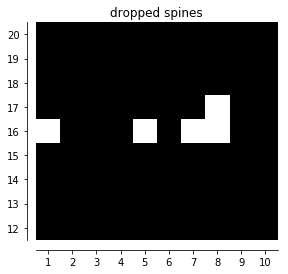

In [76]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

m = learner.player.policy.strategy_matrix()

for i in range(5):
    pl.clf()
    fig, ax = plt.subplots()
    plot_policy(np.flipud(m), ax)
    display.display(fig)
    display.clear_output(wait=True)
    m[i] = [0] * 10
    time.sleep(1)


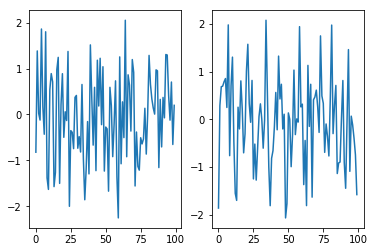

In [71]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.clf()
    f, ax = pl.subplots(1, 2)
    ax[0].plot(pl.randn(100))
    ax[1].plot(pl.randn(100))
    display.display(f)
    display.clear_output(wait=True)
    time.sleep(1.0)